In [1]:
import io
import json
import re
import unicodedata
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM,  Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare Data

In [2]:
df = pd.read_csv("/kaggle/input/language-translation-englishfrench/eng_-french.csv")
df = df.sample(frac=1)
df.head(3)

,English words/sentences,French words/sentences
34883,I don't know English.,J'ignore l'anglais.
10349,Go back to work.,Retournez au travail !
114253,I am married and I have two sons.,Je suis marié et j'ai deux fils.


In [3]:
train_ratio = 0.8
val_ratio = 0.2

train = df.iloc[:int(len(df) * 0.8)]
val = df.iloc[int(len(df) * 0.8):]

assert(len(train) + len(val) == len(df))
len(train), len(val)

(140496, 35125)

In [4]:
# unicode normalization
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# retain punctuation, delete whitespace
def preprocess(s):
    s = normalize_unicode(s)
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = s.strip()
    return s

# add <sos>, <eos> tags
def tag_sentences(sentences):
    tagged_sentences = map(lambda s: ' '.join(['<sos>', s, '<eos>']), sentences)
    return list(tagged_sentences)

In [5]:
def prepare_data(input_sentences, output_sentences, input_tokenizer, output_tokenizer, fit_tokenizer, max_encoding_length, max_decoding_length):
    input_sentences_preprocessed = [preprocess(sentence) for sentence in input_sentences]
    output_sentences_preprocessed = [preprocess(sentence) for sentence in output_sentences]
    output_sentences_preprocessed = tag_sentences(output_sentences_preprocessed)
    if fit_tokenizer:
        input_tokenizer.fit_on_texts(input_sentences_preprocessed)
        output_tokenizer.fit_on_texts(output_sentences_preprocessed)
    INPUT_VOCAB_SIZE = len(input_tokenizer.word_index) + 1
    OUTPUT_VOCAB_SIZE = len(output_tokenizer.word_index) + 1
    input_sequences = input_tokenizer.texts_to_sequences(input_sentences_preprocessed)
    output_sequences = output_tokenizer.texts_to_sequences(output_sentences_preprocessed)
    decoder_inputs = [sequence[:-1] for sequence in output_sequences]
    decoder_targets = [sequence[1:] for sequence in output_sequences]
    encoder_inputs = pad_sequences(input_sequences, maxlen=max_encoding_length, padding='post', truncating='post')
    decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_decoding_length, padding='post', truncating='post')
    decoder_targets = pad_sequences(decoder_targets, maxlen=max_decoding_length, padding='post', truncating='post')
    return encoder_inputs, decoder_inputs, decoder_targets, INPUT_VOCAB_SIZE, OUTPUT_VOCAB_SIZE

In [6]:
train_input_sentences = list(train['French words/sentences'].values)
train_output_sentences = list(train['English words/sentences'].values)
val_input_sentences = list(val['French words/sentences'].values)
val_output_sentences = list(val['English words/sentences'].values)

In [7]:
input_tokenizer = Tokenizer(oov_token='<UNK_IN>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
output_tokenizer = Tokenizer(oov_token='<UNK_OUT>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')

In [8]:
MAX_ENCODING_LENGTH = int(df['French words/sentences'].apply(lambda x: len(x.split())).quantile(0.95))
MAX_DECODING_LENGTH = int(df['English words/sentences'].apply(lambda x: len(x.split())).quantile(0.95)) - 1

In [9]:
encoder_inputs_train, decoder_inputs_train, decoder_targets_train, INPUT_VOCAB_SIZE, OUTPUT_VOCAB_SIZE = prepare_data(train_input_sentences, train_output_sentences, input_tokenizer, output_tokenizer, True, MAX_ENCODING_LENGTH, MAX_DECODING_LENGTH)
encoder_inputs_val, decoder_inputs_val, decoder_targets_val, _, _ = prepare_data(val_input_sentences, val_output_sentences, input_tokenizer, output_tokenizer, False, MAX_ENCODING_LENGTH, MAX_DECODING_LENGTH)

In [10]:
input_tokenizer_json = input_tokenizer.to_json()
with io.open('fr_input_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(input_tokenizer_json, ensure_ascii=False))
output_tokenizer_json = output_tokenizer.to_json()
with io.open('en_output_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(output_tokenizer_json, ensure_ascii=False))

## Model

In [11]:
encoder_inputs = Input(shape=[None])
encoder_embeddings = Embedding(input_dim=INPUT_VOCAB_SIZE,
                               output_dim=256,
                               mask_zero=True)(encoder_inputs)
_, state_h, state_c = LSTM(units=1024,
                           return_state=True,
                           return_sequences=False,
                           dropout=0.2)(encoder_embeddings)
encoder_states = [state_h, state_c]

In [12]:
decoder_inputs = Input(shape=[None])
decoder_embeddings = Embedding(input_dim=OUTPUT_VOCAB_SIZE,
                               output_dim=256,
                               mask_zero=True)(decoder_inputs)
decoder_lstm, _, _ = LSTM(units=1024,
                           return_state=True,
                           return_sequences=True,
                           dropout=0.2)(decoder_embeddings, initial_state=encoder_states)
decoder_dense = Dense(units=OUTPUT_VOCAB_SIZE, 
                      activation='softmax')(decoder_lstm)

In [13]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], 
                       outputs=decoder_dense,
                       name='french-english-translation')

In [14]:
model.summary()

Model: "french-english-translation"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            6915072   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            3474432   ['input_2[0][0]']             
                                                                         

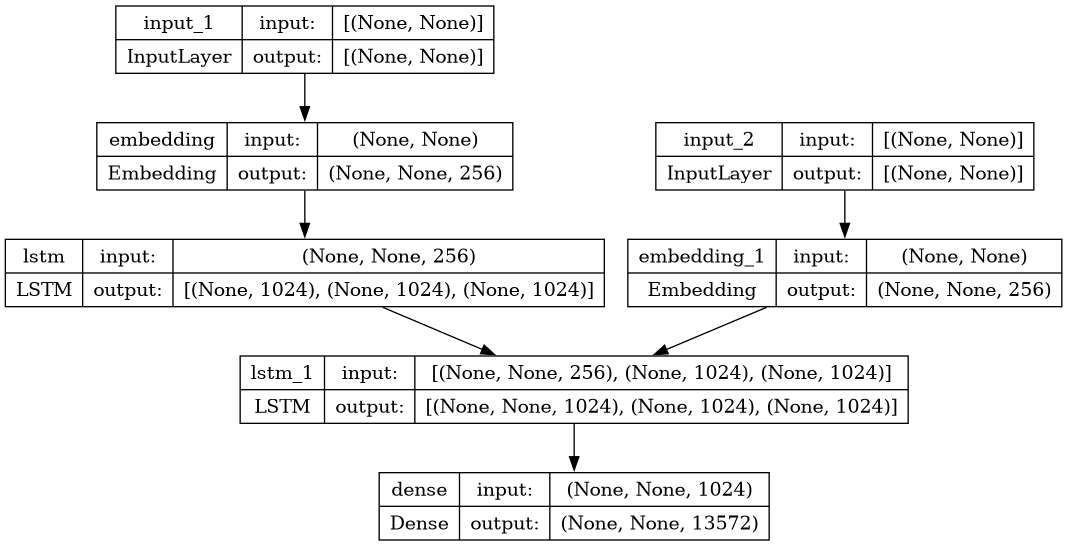

In [15]:
plot_model(model, show_shapes=True)

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

In [17]:
callback = EarlyStopping(monitor='val_accuracy', 
                         patience=3,
                         restore_best_weights=True)

In [18]:
history = model.fit([encoder_inputs_train, decoder_inputs_train],
                    decoder_targets_train,
                    validation_data=([encoder_inputs_val, decoder_inputs_val], decoder_targets_val),
                    epochs=15,
                    batch_size=70,
                    callbacks=[callback])

Epoch 1/15
2008/2008 [==============================] - 127s 58ms/step - loss: 3.6078 - accuracy: 0.3930 - val_loss: 2.7050 - val_accuracy: 0.5104
Epoch 2/15
2008/2008 [==============================] - 96s 48ms/step - loss: 2.1984 - accuracy: 0.5762 - val_loss: 1.9174 - val_accuracy: 0.6335
Epoch 3/15
2008/2008 [==============================] - 95s 47ms/step - loss: 1.4549 - accuracy: 0.6898 - val_loss: 1.5229 - val_accuracy: 0.7047
Epoch 4/15
2008/2008 [==============================] - 94s 47ms/step - loss: 0.9875 - accuracy: 0.7708 - val_loss: 1.3504 - val_accuracy: 0.7400
Epoch 5/15
2008/2008 [==============================] - 94s 47ms/step - loss: 0.6909 - accuracy: 0.8296 - val_loss: 1.2726 - val_accuracy: 0.7620
Epoch 6/15
2008/2008 [==============================] - 94s 47ms/step - loss: 0.5006 - accuracy: 0.8719 - val_loss: 1.2487 - val_accuracy: 0.7730
Epoch 7/15
2008/2008 [==============================] - 94s 47ms/step - loss: 0.3724 - accuracy: 0.9017 - val_loss: 1.2546 

In [19]:
model.save('french-english-translation-model')
!zip -r ./french-english-translation-model.zip ./french-english-translation-model

  adding: french-english-translation-model/ (stored 0%)
  adding: french-english-translation-model/keras_metadata.pb (deflated 90%)
  adding: french-english-translation-model/fingerprint.pb (stored 0%)
  adding: french-english-translation-model/assets/ (stored 0%)
  adding: french-english-translation-model/saved_model.pb (deflated 90%)
  adding: french-english-translation-model/variables/ (stored 0%)
  adding: french-english-translation-model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: french-english-translation-model/variables/variables.index (deflated 63%)
